### Test LinUCB, ThresholdBandit and GreedyBandit

In [1]:
%cd /home/lansdell/projects/conservativerdd
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

from lib.bandits import LinUCB, ThresholdBandit,GreedyBandit, ConsLinUCB, expected_regret, expected_regret_per_arm
from lib.generator import LinearGeneratorParams, LinearGenerator
import numpy as np 

import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import seaborn as sns
sns.set_style('ticks')

/home/lansdell/projects/conservativerdd
Populating the interactive namespace from numpy and matplotlib


In [2]:
#alg = 'greedy'
#alg = 'linucb'
#alg = 'threshold'
#alg = 'thresholdcons'
alg = 'conslinucb'

M = 3    #number of runs
N = 10000 #number of timesteps
save = False
alpha = 0.1 #CLUCB parameter...
max_alpha = 2
max_beta = 2
k = 4    #Number of arms
d = 5   #Dimension of context (includes one dim for intercept term)
intercept = True
evaluate_every = 100

if alg == 'greedy':
	BanditAlg = GreedyBandit
elif alg == 'linucb':
	BanditAlg = LinUCB
elif alg == 'threshold':
	BanditAlg = ThresholdBandit
elif alg == 'thresholdcons':
	BanditAlg = ThresholdConsBandit
elif alg == 'conslinucb':
	BanditAlg = ConsLinUCB
else:
	print("Select a valid algorithm")

## Run CLUCB 

In [3]:
#Generate slopes and intercepts
alphas = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,k,d-1))
betas = truncnorm.rvs(-max_beta, max_beta, scale = 1, size=(M,k))

#baseline_alphas = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,1,d-1))
#baseline_betas = truncnorm.rvs(-max_beta, max_beta, scale = 1, size=(M,1))

regret = np.zeros((M, N))
expt_regret = np.zeros((M, N))
arm_pulls = np.zeros((M, N, k+1))
n_changes = np.zeros((M, N))
update_pol = np.zeros((M, N))

In [4]:
print("Running %s algorithm"%alg)
for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    means = expected_regret_per_arm(generator)
    #Choose the baseline arm as the worst arm....
    m_idx = np.argmin(means)
    base_alpha = alphas[m,m_idx,:]
    base_beta = betas[m,m_idx]
    #bandit = BanditAlg(generator, (np.squeeze(baseline_alphas[m,:]), baseline_betas[m,0]), alpha = 0.1)
    bandit = BanditAlg(generator, (base_alpha, base_beta), alpha = alpha)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        regret[m,i] = r
        if arm_idx >= 0:
            arm_pulls[m,i,arm_idx] = 1
        else:
            arm_pulls[m,i,k] = 1

Running conslinucb algorithm
Run: 1/3
Run: 2/3
Run: 3/3


## LinUCB for comparison

In [5]:
BanditAlg = LinUCB    
regret_linucb = np.zeros((M, N))
arm_pulls_linucb = np.zeros((M, N, k+1))

In [6]:
for m in range(M):
	params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
	generator = LinearGenerator(params)
	bandit = BanditAlg(generator)
	print("Run: %d/%d"%(m+1,M))
	for i in range(N):
		(ctx, arm_idx, obs, r) = bandit.step()
		regret_linucb[m,i] = r
		if arm_idx >= 0:
			arm_pulls_linucb[m,i,arm_idx] = 1
		else:
			arm_pulls_linucb[m,i,k] = 1

Run: 1/3
Run: 2/3
Run: 3/3


## Comparison of the two methods

Trade-off between convergence rate, risk, and confidence level

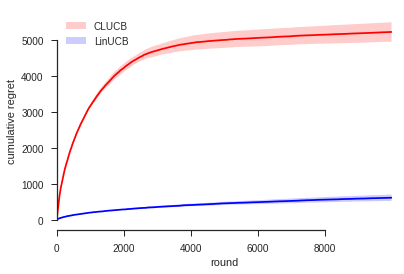

In [7]:
#Vary the confidence level, plot convergence rate, regret, risk
sns.tsplot(np.cumsum(regret, axis = 1), color = 'red')
sns.tsplot(np.cumsum(regret_linucb, axis = 1), color = 'blue')
plt.xlabel('round')
plt.ylabel('cumulative regret')
plt.legend(['CLUCB', 'LinUCB'])
sns.despine(trim = True)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


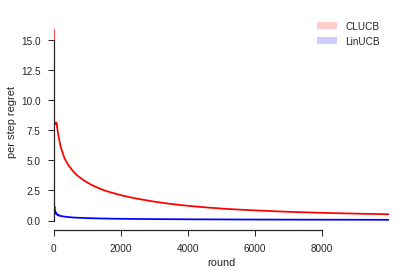

In [8]:
#Vary the confidence level, plot convergence rate, regret, risk
sns.tsplot(np.divide(np.cumsum(regret, axis = 1), np.arange(N)), color = 'red')
sns.tsplot(np.divide(np.cumsum(regret_linucb, axis = 1),np.arange(N)), color = 'blue')
plt.xlabel('round')
plt.ylabel('per step regret')
plt.legend(['CLUCB', 'LinUCB'])
sns.despine(trim = True)

## Plot the violation of constraints........